In [2]:
%load_ext line_profiler

In [1]:
import torch
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from time import time

In [4]:
from importlib import reload

import GTN2
reload(GTN2)
from GTN2 import *

In [5]:
from importlib import reload

import utils
reload(utils)
from utils import *

In [26]:
from importlib import reload

import GTN2_torch
reload(GTN2_torch)
from GTN2_torch import *

In [31]:
from importlib import reload

import utils_torch
reload(utils_torch)
from utils_torch import *

In [5]:
from importlib import reload

import plot_utils
reload(plot_utils)
from plot_utils import *

In [9]:
def measure_feedback_layer(gtn2,):
    # margin_x=0 if gtn2.bcx==1 else gtn2.nshell
    margin_x=0 
    ilist = range(margin_x,gtn2.Lx-margin_x)
    # margin_y=0 if gtn2.bcy==1 else gtn2.nshell
    margin_y=0
    jlist = range(margin_y,gtn2.Ly-margin_y)
    ij_list = [(i,j) for i in (ilist) for j in (jlist)]
    for i,j in (ij_list):
        gtn2.measure_feedback(ij = [i,j])

In [10]:
def randomize(gtn2,measure=True):
    for i in tqdm(range(2*gtn2.L+1,4*gtn2.L,2),desc='randomize'):
        # print([i, (i+1)%(2*gtn2.L)+2*gtn2.L])
        gtn2.randomize([i, (i+1)%(2*gtn2.L)+2*gtn2.L])
    if measure:
        for i in tqdm(range(2*gtn2.L,4*gtn2.L,2),desc='measure'):
            gtn2.measure_single_mode_Born([i,i+1],mode=[1])

# Dense

In [9]:
gtn2=GTN2(Lx=20,Ly=20,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,sparse=False)

# op=kraus([0,1/np.sqrt(2),1/np.sqrt(2)])
# ix = np.arange(0,2).tolist()
# ix_bar = np.arange(2,gtn2.C_m.shape[0]).tolist()
op=(op_single_mode(((1,)*50,1)))
ix = np.arange(0,100).tolist()
ix_bar = np.arange(100,gtn2.C_m.shape[0]).tolist()

In [149]:
Gamma=gtn2.C_m.copy()

In [153]:
P_contraction_2(gtn2.C_m,op,ix,ix_bar,)

In [104]:
%timeit P_contraction_2(gtn2.C_m,op,ix,ix_bar,)

543 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Torch

In [191]:
gtn2_torch=GTN2_torch(Lx=15,Ly=15,history=False,random_init=False,random_U1=True,bcx=1,bcy=1,seed=1,orbit=2,nshell=2,layer=2,replica=2,complex128=True)

mu_list=[1]
gtn2_torch.a_i={}
gtn2_torch.b_i={}
gtn2_torch.A_i={}
gtn2_torch.B_i={}
for mu in mu_list:
    gtn2_torch.a_i[mu],gtn2_torch.b_i[mu] = amplitude(gtn2_torch.nshell,tau=[0,1],geometry='square',lower=True,mu=mu,C=1)
    gtn2_torch.A_i[mu],gtn2_torch.B_i[mu] = amplitude(gtn2_torch.nshell,tau=[1,0],geometry='square',lower=False,mu=mu,C=1)

Using cuda


In [192]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2_torch.generate_tripartite_circle()
nu_list.append(chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))


In [193]:
for i in tqdm(range(5)):
    randomize(gtn2_torch,measure=True)
    measure_feedback_layer(gtn2_torch)
    nu_list.append( chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))


100%|██████████| 5/5 [01:14<00:00, 14.81s/it]


In [194]:
ilist=np.arange(0,gtn2_torch.Lx)
jlist=np.arange(0,gtn2_torch.Ly)
subregion_m = torch.hstack((
    torch.from_numpy(gtn2_torch.linearize_idx_span(ilist = ilist,jlist=jlist,layer=0)).cuda(),
    torch.from_numpy(gtn2_torch.linearize_idx_span(ilist = ilist,jlist=jlist,layer=1)).cuda())
)

EC=gtn2_torch.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2_torch.C_m)
EC_grid=EC.reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2)).cpu().numpy()

(<matplotlib.image.AxesImage at 0x7fd83a9035e0>,
 <matplotlib.collections.PathCollection at 0x7fd83a9d93c0>)

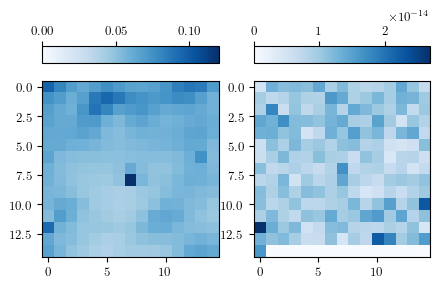

In [208]:
fig,ax=plt.subplots(1,2,figsize=(5,2.5))
plot_EC(EC_grid,ax=ax,vmax=None)

In [196]:
C_r=gtn2_torch.local_Chern_marker(gtn2_torch.C_m,)

(<matplotlib.image.AxesImage at 0x7fd8421a5a80>,
 <matplotlib.collections.PathCollection at 0x7fd83efc1ab0>)

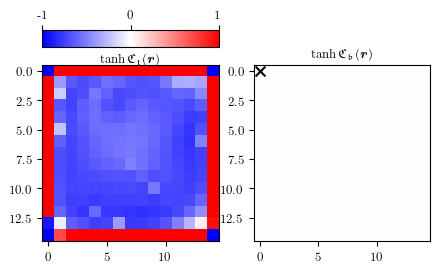

In [197]:
fig,ax=plt.subplots(1,2,figsize=(5,2.5))
plot_C_r(C_r.cpu()[0],ax=ax,bottomcb=False,label_pos=[None,(0,0)])

# DW

In [56]:
def measure_feedback_layer_dw_line(gtn2,overlap,geometry,truncate=False):
    ilist = range(gtn2.Lx)
    jlist = range(gtn2.Ly)
    ij_list = [(i,j) for i in (ilist) for j in (jlist)]
    margin=0 if overlap else gtn2.nshell
    inner_list = range(gtn2.Lx//5+margin,gtn2.Lx//5*4-margin)
    outer_list = range(gtn2.Lx//5-margin,gtn2.Lx//5*4+margin)
    if geometry == 'square':
        inner_region=set([(i,j) for i in inner_list for j in inner_list])
        outer_region=set([(i,j) for i in ilist for j in jlist if i not in outer_list or j not in outer_list])
    elif geometry == 'strip':
        inner_region=set([(i,j) for i in inner_list for j in jlist])
        outer_region=set([(i,j) for i in ilist for j in jlist if i not in outer_list])
    region_inner=inner_region if truncate else None
    region_outer=outer_region if truncate else None
    for i,j in tqdm(ij_list,desc='measure with feedback'):
        if (i,j) in inner_region:
            gtn2.measure_feedback(ij = [i,j],mu=1,region=region_inner)
        elif (i,j) in outer_region:
            gtn2.measure_feedback(ij = [i,j],mu=3,region=region_outer)


In [75]:
gtn2=GTN2_torch(Lx=20,Ly=20,history=False,random_init=False,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,replica=2,)


mu_list=[1,3]
gtn2.a_i={}
gtn2.b_i={}
gtn2.A_i={}
gtn2.B_i={}
for mu in mu_list:
    gtn2.a_i[mu],gtn2.b_i[mu] = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=mu)
    gtn2.A_i[mu],gtn2.B_i[mu] = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=mu)


Using cuda


In [76]:
# nu_list =[]
# A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

ilist=np.arange(0,gtn2.Lx)
jlist=np.arange(0,gtn2.Ly)
subregion_m = torch.hstack((
    torch.from_numpy(gtn2.linearize_idx_span(ilist = ilist,jlist=jlist,layer=0)).cuda(),
    torch.from_numpy(gtn2.linearize_idx_span(ilist = ilist,jlist=jlist,layer=1)).cuda())
)
EC_list=[]
C_r_list=[]

In [77]:
# nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
EC_list.append( gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))) 
C_r_list.append( gtn2.local_Chern_marker(gtn2.C_m,))

for i in (range(10)):
    measure_feedback_layer_dw_line(gtn2,overlap=True,geometry='strip',truncate=True)
    randomize(gtn2,measure=True)
    
    # nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
    st=time()
    EC_list.append( gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))) 
    C_r_list.append( gtn2.local_Chern_marker(gtn2.C_m,))
    print(f'{time()-st:.2f}')




measure: 100%|██████████| 800/800 [00:13<00:00, 60.27it/s]


3.68


measure: 100%|██████████| 800/800 [00:13<00:00, 60.25it/s]


3.68


measure: 100%|██████████| 800/800 [00:13<00:00, 60.26it/s]


3.68


measure: 100%|██████████| 800/800 [00:13<00:00, 60.26it/s]


3.68


measure: 100%|██████████| 800/800 [00:13<00:00, 60.28it/s]


3.68


measure: 100%|██████████| 800/800 [00:13<00:00, 60.30it/s]


3.67


measure: 100%|██████████| 800/800 [00:13<00:00, 60.27it/s]


3.67


measure: 100%|██████████| 800/800 [00:13<00:00, 60.28it/s]


3.68


measure: 100%|██████████| 800/800 [00:18<00:00, 42.24it/s]


4.29


measure: 100%|██████████| 800/800 [00:13<00:00, 60.31it/s]


3.67


In [16]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float)

0.0

In [31]:
%lprun -f gtn2.entanglement_contour EC=gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))


Timer unit: 1e-09 s

Total time: 22.1754 s
File: /home/hnpan/GTN/GTN2_torch.py
Function: entanglement_contour at line 318

Line #      Hits         Time  Per Hit   % Time  Line Contents
   318                                               def entanglement_contour(self,subregion,fermion=False, Gamma=None, fermion_idx=True,n=1):
   319                                                   # c_A=self.c_subregion_m(subregion)
   320         1     627703.0 627703.0      0.0          c_A=self.c_subregion_m(subregion,Gamma,fermion_idx=fermion_idx)
   321         1     414231.0 414231.0      0.0          C_f=(torch.eye(c_A.shape[0],device=self.device)+1j*c_A)/2
   322         1        872.0    872.0      0.0          if n==1:
   323         1 22174311030.0 22174311030.0    100.0              f=self.xlogx(C_f,)
   324                                                   # else:
   325                                                   #     f=
   326         1        591.0    591.0      0.0          if

In [41]:
EC_list.append(gtn2.get_C_f(gtn2.C_m,))

In [46]:
EC_list[-1].nelement()*EC_list[-1].element_size()

6400

In [36]:
%lprun -f gtn2.local_Chern_marker gtn2.local_Chern_marker(gtn2.C_m,)

Timer unit: 1e-09 s

Total time: 9.63202 s
File: /home/hnpan/GTN/GTN2_torch.py
Function: local_Chern_marker at line 304

Line #      Hits         Time  Per Hit   % Time  Line Contents
   304                                               def local_Chern_marker(self,Gamma,shift=[0,0],n_maj=2,U1=True):
   305         1     362611.0 362611.0      0.0          replica,layer,x,y,orbit,maj = np.unravel_index(np.arange(Gamma.shape[0]),(self.replica,self.layer,self.Lx,self.Ly,self.orbit,n_maj))
   306         1 9629811156.0 9629811156.0    100.0          x = torch.tensor((x+shift[0])%self.Lx,device=self.device)
   307         1     123819.0 123819.0      0.0          y = torch.tensor((y+shift[1])%self.Ly,device=self.device)
   308         1     233441.0 233441.0      0.0          C_f = self.get_C_f(Gamma,normal=False)
   309         1    1397462.0 1397462.0      0.0          xy_comm = torch.einsum("ij,j,jk,k,ki->i",C_f,x,C_f,y,C_f) - torch.einsum("ij,j,jk,k,ki->i",C_f,y,C_f,x,C_f)
   310       

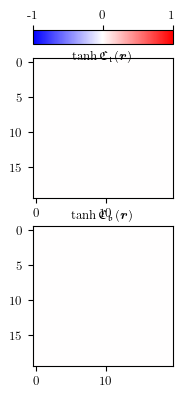

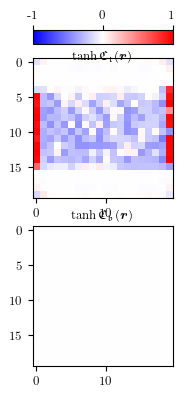

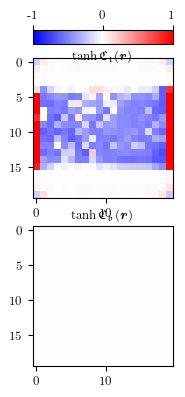

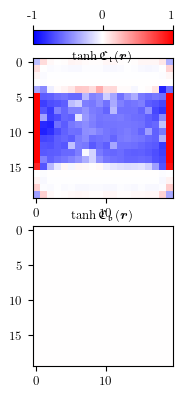

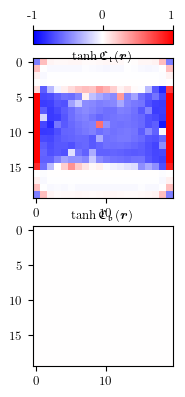

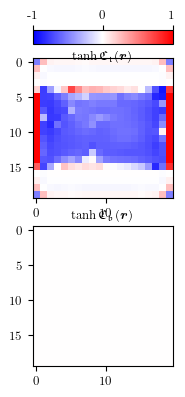

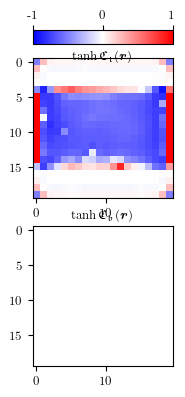

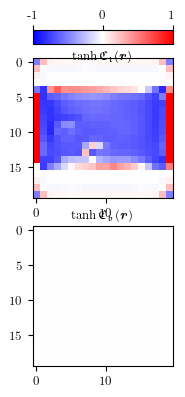

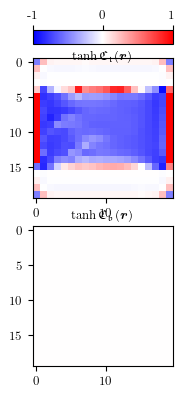

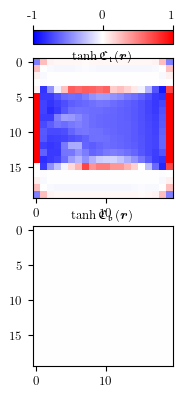

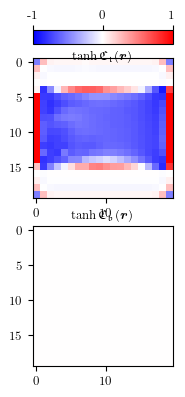

In [81]:
for idx in range(len(C_r_list)):
    fig,ax=plt.subplots(2,1)
    plot_C_r(C_r_list[idx][0].cpu(),ax,bottomcb=False)

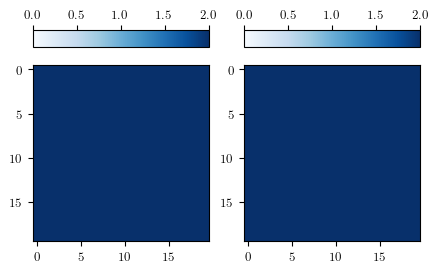

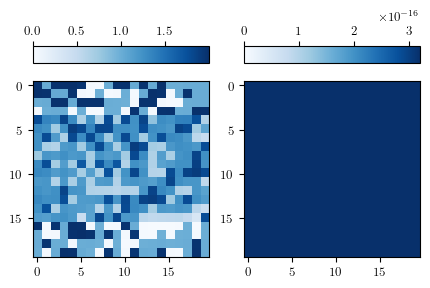

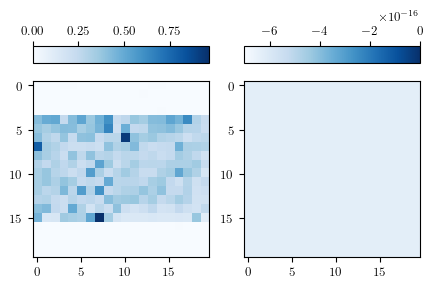

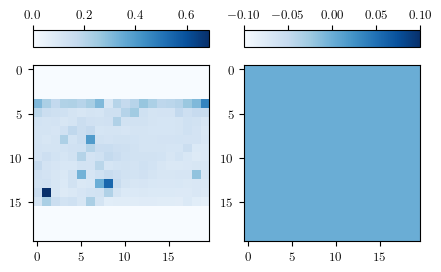

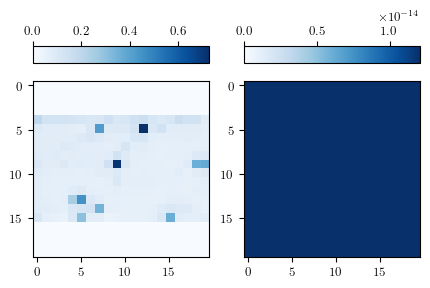

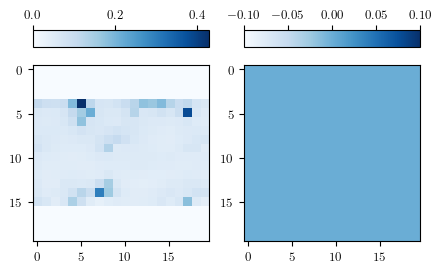

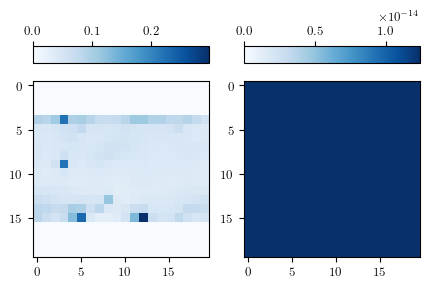

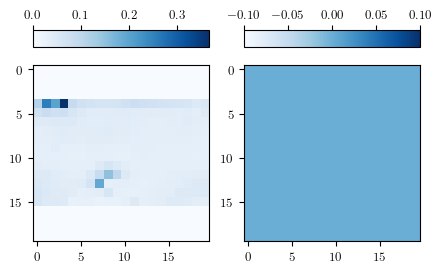

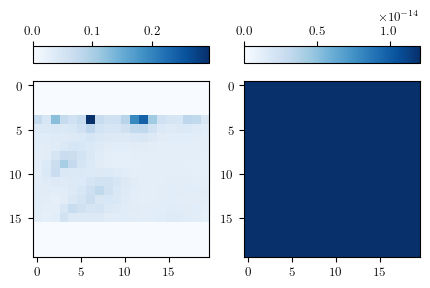

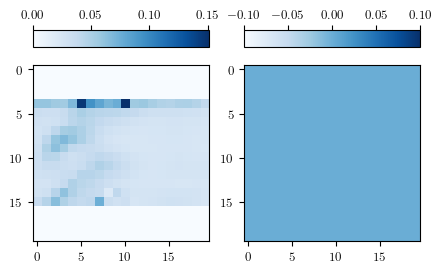

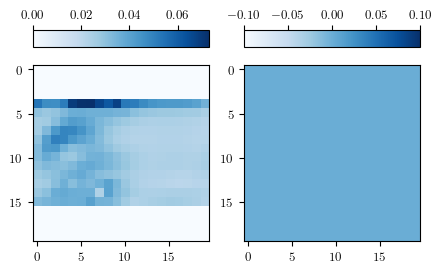

In [82]:
for idx in range(len(EC_list)):
    fig,ax=plt.subplots(1,2,figsize=(5,2.5))
    plot_EC(EC_list[idx].cpu(),ax=ax,vmax=None)

In [ ]:
fig,ax=plt.subplots(figsize=(4,4),)
im=ax.imshow((EC_list[-1][0])/np.log(2),cmap='Blues',vmin=0,)
axins=ax.inset_axes([0.,1.15,1,0.1])
plt.colorbar(im,cax=axins,label='EC',orientation='horizontal')
ax.set_xlabel('$j$')
ax.set_ylabel('$i$')

In [ ]:
for i in tqdm(range(5)):
    randomize(gtn2_torch,measure=True)
    measure_feedback_layer(gtn2_torch)
    nu_list.append( chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))


In [23]:
def run(seed):
    gtn2_torch=GTN2_torch(Lx=15,Ly=15,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=seed,orbit=2,nshell=2,layer=2,complex128=True)

    mu_list=[1]
    gtn2_torch.a_i={}
    gtn2_torch.b_i={}
    gtn2_torch.A_i={}
    gtn2_torch.B_i={}
    for mu in mu_list:
        gtn2_torch.a_i[mu],gtn2_torch.b_i[mu] = amplitude(gtn2_torch.nshell,tau=[0,1],geometry='square',lower=True,mu=mu,C=1)
        gtn2_torch.A_i[mu],gtn2_torch.B_i[mu] = amplitude(gtn2_torch.nshell,tau=[1,0],geometry='square',lower=False,mu=mu,C=1)

    nu_list =[]
    A_idx_0,B_idx_0,C_idx_0 = gtn2_torch.generate_tripartite_circle()
    nu_list.append(chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))
    for i in tqdm(range(15)):
        randomize(gtn2_torch,measure=True)
        measure_feedback_layer(gtn2_torch)
        nu_list.append( chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))
    return nu_list



In [30]:
nu_map=[run(seed) for seed in range(10)]

Using cuda


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


Using cuda


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


Using cuda


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


Using cuda


100%|██████████| 15/15 [01:13<00:00,  4.92s/it]


Using cuda


100%|██████████| 15/15 [01:08<00:00,  4.60s/it]


Using cuda


100%|██████████| 15/15 [01:09<00:00,  4.62s/it]


Using cuda


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]


Using cuda


100%|██████████| 15/15 [01:08<00:00,  4.59s/it]


Using cuda


100%|██████████| 15/15 [01:05<00:00,  4.35s/it]


Using cuda


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


In [31]:
np.array(nu_map).mean(axis=0)

array([ 0.        , -0.04340977, -0.34118164, -0.58557048, -0.72809567,
       -0.80178432, -0.9012831 , -0.89978565, -0.90688876, -0.93314187,
       -0.95130403, -0.96899952, -0.96879417, -0.96250813, -0.96780333,
       -0.96802397])

In [32]:
np.array(nu_map)

array([[ 0.        , -0.0470636 , -0.24713074, -0.65300245, -0.80022849,
        -0.86543006, -0.99478705, -0.9880003 , -0.95746157, -0.97036542,
        -0.97274476, -0.97279943, -0.97237429, -0.97170929, -1.01191812,
        -1.00798895],
       [ 0.        , -0.07574187, -0.36742756, -0.52419283, -0.67299597,
        -0.73694809, -0.90405806, -0.86354636, -0.87415533, -0.88603411,
        -0.92309873, -0.94471137, -0.95917501, -0.9776012 , -0.99098254,
        -0.99973385],
       [ 0.        , -0.03845409, -0.35252488, -0.77188625, -0.8059878 ,
        -0.75162773, -0.69411202, -0.60134566, -0.62528195, -0.90762924,
        -0.9140761 , -0.92024815, -0.92584076, -0.93066441, -0.93472988,
        -0.93810808],
       [ 0.        ,  0.00674072, -0.23442403, -0.30174371, -0.43350432,
        -0.47409661, -1.04409315, -1.06590599, -0.93790064, -0.93760884,
        -0.99827835, -0.98794229, -0.97993197, -0.9734858 , -0.9681501 ,
        -0.96368206],
       [ 0.        , -0.07197462, -0

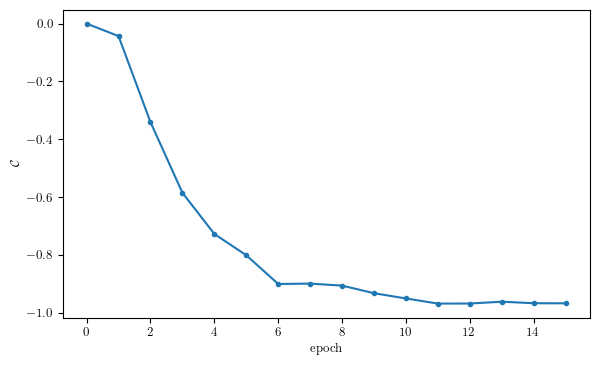

In [33]:
plot_chern(np.array(nu_map).mean(axis=0))

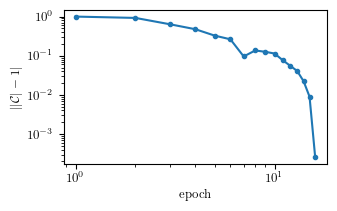

In [34]:
fig,ax=plt.subplots(figsize=(3.4,2))
plot_chern(nu_list,log=True,C=1,ax=ax)
# fig.savefig('C0C1_log.pdf',bbox_inches='tight')

In [24]:
z1=purify(z1)

In [25]:
torch.linalg.svdvals(z1)

tensor([1.0015, 1.0015, 1.0015,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')

# Load

In [2]:
# rs = torch.load('class_A_2D_L10_nshell2_tf10.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf30.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf50_truncate.pt', map_location='cpu')

# rs = torch.load('class_A_2D_L30_nshell2_tf40_truncate.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L30_nshell2_tf30.pt', map_location='cpu')

rs = torch.load('class_A_2D_L35_nshell2_tf50_truncate.pt', map_location='cpu')

In [ ]:
for idx in range(len(rs['C_r'])):
    fig,ax=plt.subplots(2,1)
    plot_C_r(rs['C_r'][idx][0],ax,bottomcb=False)

In [ ]:
for idx in range(len(rs['EC'])):
    fig,ax=plt.subplots(1,2,figsize=(5,2.5))
    plot_EC(rs['EC'][idx],ax=ax,vmax=None)

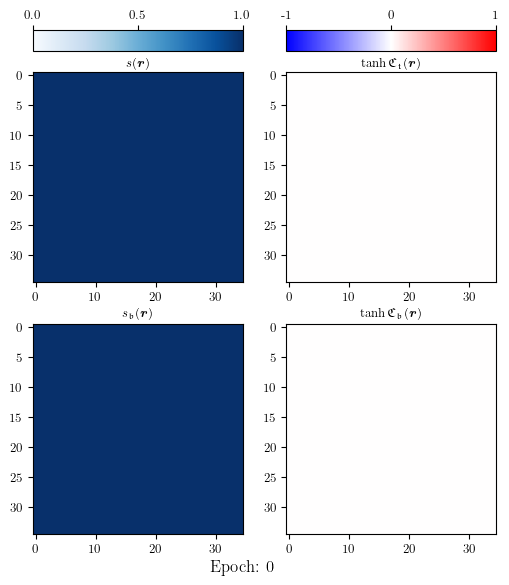

In [6]:
fig,ax=plt.subplots(2,2,figsize=(6,6),)
i=0

epoch=ax[1,0].text(1,-0.18,f'Epoch: {i}',transform=ax[1,0].transAxes,ha='center',fontsize=12)
ax_C=ax[:,1]
im0,im1,cross0,cross1=plot_C_r(rs['C_r'][i][0],ax=ax_C,bottomcb=False,)

ax_EC=ax[:,0]
EC_im0,EC_im1,EC_cross0,EC_cross1,EC_cb0,EC_cb1=plot_EC(rs['EC'][i],ax=ax_EC,bottomcb=False,vmax=1)




# fig.savefig('C_m_history.png')

In [7]:
def update(frame):
    print(frame)
    im0.set_data(np.tanh(rs['C_r'][frame][0,0]))
    im1.set_data(np.tanh(rs['C_r'][frame][0,1]))
    EC_im0.set_data(rs['EC'][frame][0]/np.log(2))
    EC_im1.set_data(rs['EC'][frame][1]/np.log(2))
    epoch.set_text(f'Epoch: {frame}')
    if frame>8:
        EC_im0.set_clim(vmin=0,vmax=0.03)
        EC_im1.set_clim(vmin=0,vmax=0.03)
        EC_cb0.update_normal(EC_im0)
        EC_cb0.set_ticks([0,0.03])
        EC_cb0.ax.xaxis.set_ticks_position('top')
        
        


In [8]:
import matplotlib.animation as animation

In [9]:
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=range(len(rs['C_r'])),  # Generate frames from 0 to 40
    # frames=range(i,i+10),  # Generate frames from 0 to 40
    blit=False    # Blit optimizes the rendering
)

In [10]:
ani.save('L35_truncate_50.mp4', writer='ffmpeg', fps=3,dpi=200)
# ani.save('L30_overlap.mp4', writer='ffmpeg', fps=3,dpi=200)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [150]:
z0=gtn2_torch.C_m.cpu().clone()

In [153]:
measure_feedback_layer(gtn2_torch)

100%|██████████| 400/400 [00:04<00:00, 98.43it/s] 


In [159]:
%timeit measure_feedback_layer(gtn2_torch)

100%|██████████| 400/400 [00:02<00:00, 163.19it/s]

2.73 s ± 299 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit measure_feedback_layer(gtn2_torch)

100%|██████████| 400/400 [00:02<00:00, 180.89it/s]

2.38 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
z1=gtn2_torch.C_m.cpu().clone()

In [155]:
torch.allclose(z0,z1)

True

In [68]:
torch.allclose(z0,gtn2_torch.C_m.cpu())

True

In [16]:
torch.abs(torch.einsum(gtn2_torch.C_m,[0,1],gtn2_torch.C_m,[1,0],[0])+1).max()

tensor(2.3452e-06, device='cuda:0', dtype=torch.float64)

In [18]:
def purify(A):
    # purify A, see App. B2 in PhysRevB.106.134206
    U, _, Vh=torch.linalg.svd(A)
    return U@Vh

In [19]:
z=purify(gtn2_torch.C_m)

In [23]:
torch.abs(torch.einsum(z,[0,1],z,[1,0],[0])+1).max()

tensor(2.6246e-13, device='cuda:0', dtype=torch.float64)

In [24]:
gtn2_torch.C_m@gtn2_torch.C_m

tensor([[-1.0000e+00, -6.9959e-16, -2.4727e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.4417e-16, -1.0000e+00,  3.8323e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.4727e-09,  3.8323e-09, -1.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.0000e+00]], device='cuda:0', dtype=torch.float64)

In [34]:
torch.abs((z@z)+torch.eye(z.shape[0],device='cuda',dtype=torch.float64)).max()

tensor(2.6201e-13, device='cuda:0', dtype=torch.float64)

In [35]:
torch.allclose((z@z),-torch.eye(z.shape[0],device='cuda',dtype=torch.float64))

True

In [97]:
%timeit measure_feedback_layer(gtn2_torch,)

100%|██████████| 400/400 [00:02<00:00, 143.36it/s]

3.05 s ± 293 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
%timeit measure_feedback_layer(gtn2_torch,)

100%|██████████| 400/400 [00:01<00:00, 301.92it/s]

1.39 s ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
z=torch.tensor([1,2,4])

In [98]:
%lprun -f gtn2_torch.measure_single_mode_Born measure_feedback_layer(gtn2_torch,)

100%|██████████| 400/400 [00:02<00:00, 142.55it/s]


Timer unit: 1e-09 s

Total time: 2.23365 s
File: /home/hnpan/GTN/GTN2_torch.py
Function: measure_single_mode_Born at line 130

Line #      Hits         Time  Per Hit   % Time  Line Contents
   130                                               def measure_single_mode_Born(self,legs,mode):
   131                                                   """measure the single mode with mode = (wf, n), wavefunction and occupation number 
   132                                                   """
   133       800  806149221.0 1007686.5     36.1          legs=torch.tensor(legs,device=self.device)
   134       800   39828639.0  49785.8      1.8          Gamma = self.C_m[legs[:,None],legs[None,:]]
   135       800  219266636.0 274083.3      9.8          n = self.get_Born_single_mode(Gamma=Gamma,mode=mode,rng=self.rng)
   136       800 1168126765.0 1460158.5     52.3          self.measure_single_mode_force(kind=(mode,n),ix=legs)
   137       800     276761.0    346.0      0.0          return (mode,n)

In [20]:
%lprun -f purify measure_feedback_layer(gtn2_torch,)

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Timer unit: 1e-09 s

Total time: 25.594 s
File: /home/hnpan/GTN/utils_torch.py
Function: purify at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def purify(A):
    49       230 25588765805.0 111255503.5    100.0      U, _, Vh=torch.linalg.svd(A)
    50       230    5228016.0  22730.5      0.0      return U@Vh

In [21]:
111255503.5/1e6

111.2555035

In [ ]:
%lprun -f purify measure_feedback_layer(gtn2_torch,)

In [18]:
%timeit torch.linalg.svd(gtn2_torch.C_m,driver='gesvd')

74.5 ms ± 8.44 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit torch.linalg.eigh(gtn2_torch.C_m/1j)

In [23]:
torch.linalg.svd(gtn2_torch.C_m,driver='gesvd')

torch.return_types.linalg_svd(
U=tensor([[-2.5537e-04,  4.4020e-02, -5.4253e-03,  ...,  1.8833e-05,
         -5.1753e-02,  2.7000e-04],
        [ 7.7587e-03, -5.6294e-02, -7.2406e-02,  ...,  8.5907e-03,
         -4.6422e-02, -9.9476e-03],
        [-1.7822e-02,  1.4610e-03,  2.3213e-02,  ...,  4.8628e-02,
         -5.2428e-02, -8.7792e-03],
        ...,
        [-2.2226e-02,  5.6293e-02, -2.2022e-02,  ..., -4.8094e-02,
         -3.8499e-03, -4.5338e-03],
        [ 5.1551e-02,  2.3581e-02, -1.5027e-02,  ..., -5.0315e-03,
          1.4565e-02, -3.5377e-02],
        [ 2.4744e-02, -3.5089e-02, -1.8049e-02,  ..., -3.0509e-02,
         -8.0133e-02, -1.4957e-03]], device='cuda:0', dtype=torch.float64),
S=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

In [28]:
z=gtn2_torch.C_m.cpu().numpy()

In [30]:
%timeit np.linalg.svd(z)

124 ms ± 813 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit np.linalg.eigh(z/1j)

126 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%lprun -f gtn2_torch.measure_single_mode_force measure_feedback_layer(gtn2_torch,)

In [14]:
%lprun -f P_contraction_torch gtn2_torch.measure_feedback([0,1])

tensor(1.7881e-06, device='cuda:0')
tensor(2.0266e-06, device='cuda:0')
tensor(2.1458e-06, device='cuda:0')
tensor(2.4438e-06, device='cuda:0')


Timer unit: 1e-09 s

Total time: 0.527896 s
File: /home/hnpan/GTN/utils_torch.py
Function: P_contraction_torch at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def P_contraction_torch(Gamma,Upsilon,ix,ix_bar,device,err,Gamma_like=None,reset_Gamma_like=True,):
     3                                               """ same analytical expression for contraction as _contraction(), differences:
     4                                               1. assume intput and output tensor have the same shape, thus, it should be Gamma(L,R) -- Upsilon (L,R), where Gamma_R = Upsilon_L =Upsilon_R, such that in-place operator is applied here.
     5                                               2. manually compute the inverse of mat2 before
     6                                               Here, Gamma is m, and proj is Upsilon
     7                                               Assume Upsilon = [A,B;C,D], the logic is to first 

In [11]:
%timeit gtn2_torch.measure_feedback([0,1])

24.4 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%timeit gtn2_torch.randomize([0,1])

74.2 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [136]:
%lprun -f gtn2_torch.measure gtn2_torch.randomize([0,1])

Timer unit: 1e-09 s

Total time: 0.00127411 s
File: /home/hnpan/GTN/GTN2_torch.py
Function: measure at line 181

Line #      Hits         Time  Per Hit   % Time  Line Contents
   181                                           
   182                                               def measure(self,n,ix):
   183                                                   ''' Majorana site index for ix, 
   184         1     315800.0 315800.0     24.8          n should be a scalar'''
   185         1      13756.0  13756.0      1.1          # ix_bar=torch.tensor(list(self.full_ix-set(ix)),device=self.device)
   186         1        361.0    361.0      0.0          self.ix_bool[ix]=True
   187         1     183645.0 183645.0     14.4          ix_bar = torch.nonzero(~self.ix_bool,as_tuple=True)[0]
   188         1     756443.0 756443.0     59.4          Psi=self.C_m
   189                                                   proj=self.kraus(n)
   190         1        852.0    852.0      0.1          P_cont

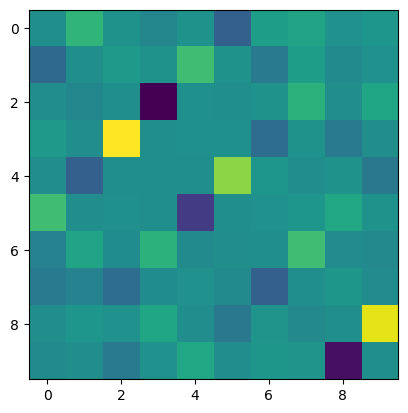

In [39]:
plt.imshow(gtn2_torch.C_m.cpu()[:10,:10])

In [8]:
device = torch.device("cuda")

In [10]:
# Ggpu=torch.from_numpy(Gamma).cuda()
op_gpu= torch.from_numpy(op).cuda()
ix_gpu = torch.from_numpy(np.array(ix)).cuda()
ix_bar_gpu = torch.from_numpy(np.array(ix_bar)).cuda()
err = torch.tensor(1e-10,device=device)

In [43]:
op

NameError: name 'op' is not defined

In [12]:
P_contraction_torch(gtn2_torch.C_m,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

In [ ]:
%lprun -f P_contraction_torch P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

In [17]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device)

42.2 ms ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

50.9 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [155]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

12.4 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

51.3 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
Ggpu

tensor([[ 0.0000,  0.9600,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9600,  0.0000,  0.0400,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0400,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -1.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  1.0000,  0.0000]],
       device='cuda:0', dtype=torch.float64)

In [188]:
Gz=purify(Ggpu)

In [190]:
torch.allclose(Gz,Ggpu)

True

In [187]:
%timeit purify(Ggpu)

1.38 s ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
val,vec=torch.linalg.eigh(Ggpu/1j)

In [177]:
U, S, Vh =torch.linalg.svd(Ggpu)

In [180]:
np.linalg.svd(np.array([[0,-1],[1,0]]))

(array([[ 0., -1.],
        [-1.,  0.]]),
 array([1., 1.]),
 array([[-1., -0.],
        [ 0.,  1.]]))

In [178]:
S

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       dtype=torch.float64)

In [185]:
torch.allclose(U@Vh,Ggpu)

True

In [176]:
Vh

tensor([[ 8.8166e-03-0.0000j,  0.0000e+00-0.0170j, -2.5560e-01-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [ 1.7594e-02-0.0000j,  0.0000e+00+0.0041j, -9.5215e-01-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [-1.3285e-01-0.0000j,  0.0000e+00-0.0639j, -1.2723e-01-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        ...,
        [-8.6209e-03-0.0000j,  0.0000e+00-0.0356j, -6.8445e-04-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [ 1.4508e-02-0.0000j,  0.0000e+00-0.0070j,  7.6398e-03-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [ 1.5218e-02-0.0000j,  0.0000e+00+0.0120j,  4.6112e-03-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j]], device='cuda:0', dtype=tor

In [168]:
vec@vec.T.conj()

tensor([[ 1.0000e+00+0.0000e+00j, -1.0971e-16+4.8945e-17j,
          3.7673e-17-6.0546e-19j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [-1.0971e-16-4.8945e-17j,  1.0000e+00+1.8705e-21j,
          7.1700e-19-5.6463e-17j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [ 3.7673e-17+6.0546e-19j,  7.1700e-19+4.9596e-17j,
          1.0000e+00-1.1297e-18j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        ...,
        [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  ...,
          1.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  ...,
          0.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          0.0000e+00+2.2371e-17j],
        [ 0.0000e+00+0

In [167]:
vec@torch.diag(val)

RuntimeError: expected scalar type ComplexDouble but found Double

In [165]:
vec@torch.diag(val)
# @vec.conj().T

RuntimeError: expected scalar type ComplexDouble but found Double

In [97]:
gtn2.C_m

array([[-1.41370405e-19,  9.14121153e-03,  8.43629885e-04, ...,
         5.45335233e-03,  9.16385308e-03, -4.98478879e-03],
       [-9.14121153e-03,  1.41370405e-19,  1.08348735e-02, ...,
        -8.01868528e-03,  9.43240753e-03, -2.38126923e-02],
       [-8.43629885e-04, -1.08348735e-02,  0.00000000e+00, ...,
         7.01912681e-04,  1.27848725e-02,  2.29915716e-04],
       ...,
       [-5.45335233e-03,  8.01868528e-03, -7.01912681e-04, ...,
         0.00000000e+00,  2.33343122e-02,  1.55717965e-02],
       [-9.16385308e-03, -9.43240753e-03, -1.27848725e-02, ...,
        -2.33343122e-02,  0.00000000e+00,  1.46735660e-02],
       [ 4.98478879e-03,  2.38126923e-02, -2.29915716e-04, ...,
        -1.55717965e-02, -1.46735660e-02,  0.00000000e+00]])

In [127]:
np.allclose(gtn2.C_m,Ggpu.cpu())

True

In [192]:
torch.tensor([[0,1.],[-1.,0]],device=device)

tensor([[ 0.,  1.],
        [-1.,  0.]], device='cuda:0')

In [197]:
device

device(type='cuda')

In [14]:
rng=torch.Generator(device=device)

In [207]:
rng.manual_seed(0)

In [16]:
# torch.normal(0,1,(10,10),generator=rng,device=device)
torch.rand(size=(10, ), generator=rng, device='cuda', dtype=torch.float32)

tensor([0.1452, 0.5480, 0.7146, 0.9941, 0.6706, 0.4023, 0.4849, 0.4496, 0.3975,
        0.3477], device='cuda:0')

In [223]:
torch.vstack([torch.arange(10),torch.arange(10)]).T

tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 3],
        [4, 4],
        [5, 5],
        [6, 6],
        [7, 7],
        [8, 8],
        [9, 9]])

In [184]:
def P_contraction_torch(Gamma,Upsilon,ix,ix_bar,device,err,Gamma_like=None,reset_Gamma_like=True,):
    """ same analytical expression for contraction as _contraction(), differences:
    1. assume intput and output tensor have the same shape, thus, it should be Gamma(L,R) -- Upsilon (L,R), where Gamma_R = Upsilon_L =Upsilon_R, such that in-place operator is applied here.
    2. manually compute the inverse of mat2 before
    Here, Gamma is m, and proj is Upsilon
    Assume Upsilon = [A,B;C,D], the logic is to first compute C= (1+ Gamma_RR @ Upsilon_LL)^{-1}, (where then B=-C.T) 
    then A= Upsilon_LL @C, D= Gamma_RR@ C.T
    ---
    reset_Gamma_like: in usual case, because each application of the gate will be like the brick layer, therefore, ix_bar will overwrite the previous. However, for the staircase pattern, one should reset it. 
    """
    Gamma_RR=Gamma[ix[:,None],ix[None,:]]
    Gamma_LR=Gamma[ix_bar[:,None],ix[None,:]]
    Upsilon_LL=Upsilon[:len(ix),:len(ix)]
    Upsilon_RR=Upsilon[len(ix):,len(ix):]
    Upsilon_RL=Upsilon[len(ix):,:len(ix)]
    eye=torch.eye(len(ix),device=device)
    try: 
        C=torch.linalg.inv(Gamma_RR@Upsilon_LL+eye)
        # lu,pivots=torch.linalg.lu_factor(Gamma_RR@Upsilon_LL+eye)
    except:
        raise ValueError("the contraction will lead to a vanishing state")
    A=Upsilon_LL@C
    D=Gamma_RR@C.T
    # A= torch.linalg.lu_solve(lu,pivots,Upsilon_LL,left=False)
    # D= torch.linalg.lu_solve(lu,pivots,Gamma_RR.T).T
    tmp=Gamma_LR@A@Gamma_LR.T
    if Gamma_like is None:
        Gamma_like=torch.zeros_like(Gamma)
    if reset_Gamma_like:
        Gamma_like.fill_(0)
    Gamma_like[ix_bar[:,None],ix_bar[None,:]]=tmp
    Gamma+=Gamma_like
    Gamma[ix[:,None],ix_bar[None,:]]=Upsilon_RL@C@Gamma_LR.T
    # Gamma[ix[:,None],ix_bar[None,:]]=torch.linalg.lu_solve(lu,pivots,Upsilon_RL,left=False)@Gamma_LR.T
    Gamma[ix[:,None],ix[None,:]]=Upsilon_RR+Upsilon_RL@D@Upsilon_RL.T
    Gamma[ix_bar[:,None],ix[None,:]]=-Gamma[ix[:,None],ix_bar[None,:]].T
    # why is it neccessary?
    # Gamma-=Gamma.T
    # Gamma/=2

    if torch.abs(torch.einsum(Gamma,[0,1],Gamma,[1,0],[0])+1).max() > err:
        Gamma=purify(Gamma)
        Gamma-=Gamma.T
        Gamma/=2


def purify(A):
    # purify A, see App. B2 in PhysRevB.106.134206
    U, _, Vh=torch.linalg.svd(A)
    return U@Vh

In [145]:
Ggpu

tensor([[ 0.0000,  0.9600,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9600,  0.0000,  0.0400,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0400,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -1.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  1.0000,  0.0000]],
       device='cuda:0', dtype=torch.float64)

In [147]:
Ggpu.shape

torch.Size([7200, 7200])